In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load input data

In [37]:
train = pd.read_csv("../data/train.csv")
store = pd.read_csv("../data/store.csv")

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Merge train and store

In [38]:
merged_train_store = pd.merge(store, train, on='Store', how='left')

In [39]:
100 * merged_train_store.isnull().sum() / len(merged_train_store)

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.264361
CompetitionOpenSinceMonth    31.760481
CompetitionOpenSinceYear     31.760481
Promo2                        0.000000
Promo2SinceWeek              49.095918
Promo2SinceYear              49.095918
PromoInterval                49.095918
Date                          0.000000
DayOfWeek                     2.981052
Sales                         2.982345
Customers                     2.993825
Open                          3.014036
Promo                         3.020665
StateHoliday                  3.007407
SchoolHoliday                 3.037643
dtype: float64

# Drop missing values

In [40]:
missing_col_5per = (100 * merged_train_store.isnull().sum() / len(merged_train_store)) < 5
cols_to_drop = merged_train_store.columns[missing_col_5per]
cols_to_drop

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2',
       'Date', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [41]:
cleaned_df = merged_train_store.dropna(axis=0, subset=cols_to_drop)
100 * cleaned_df.isnull().sum() / len(cleaned_df)

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth    31.571129
CompetitionOpenSinceYear     31.571129
Promo2                        0.000000
Promo2SinceWeek              49.080353
Promo2SinceYear              49.080353
PromoInterval                49.080353
Date                          0.000000
DayOfWeek                     0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
dtype: float64

In [42]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498126 entries, 0 to 618471
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      498126 non-null  int64  
 1   StoreType                  498126 non-null  object 
 2   Assortment                 498126 non-null  object 
 3   CompetitionDistance        498126 non-null  float64
 4   CompetitionOpenSinceMonth  340862 non-null  float64
 5   CompetitionOpenSinceYear   340862 non-null  float64
 6   Promo2                     498126 non-null  int64  
 7   Promo2SinceWeek            253644 non-null  float64
 8   Promo2SinceYear            253644 non-null  float64
 9   PromoInterval              253644 non-null  object 
 10  Date                       498126 non-null  object 
 11  DayOfWeek                  498126 non-null  float64
 12  Sales                      498126 non-null  float64
 13  Customers                  49

In [43]:
cleaned_df.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     148339
Feb,May,Aug,Nov      57724
Mar,Jun,Sept,Dec     47581
Name: PromoInterval, dtype: int64

In [44]:
cleaned_df.CompetitionOpenSinceYear

0         2008.0
2         2008.0
3         2008.0
5         2008.0
6         2008.0
           ...  
618463       NaN
618464       NaN
618465       NaN
618470       NaN
618471       NaN
Name: CompetitionOpenSinceYear, Length: 498126, dtype: float64

In [45]:
missing_promo = cleaned_df.Promo2SinceWeek.isnull()
cleaned_df[['Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']][missing_promo]['Promo2'].unique()

array([0])

# Encode the missing columns

In [46]:
mean_encode_cols = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
zero_encode_cols = ['Promo2SinceWeek', 'Promo2SinceYear']
string_encode_cols = ['PromoInterval']

In [47]:
mean_encode = np.floor(cleaned_df[mean_encode_cols].mean())
string_encode = 'unavailable'

In [48]:
cleaned_df[mean_encode_cols] = cleaned_df[mean_encode_cols].fillna(mean_encode, axis=0)
cleaned_df[zero_encode_cols] = cleaned_df[zero_encode_cols].fillna(0, axis=0)
cleaned_df[string_encode_cols] = cleaned_df[string_encode_cols].fillna(string_encode, axis=0)

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [49]:
cleaned_df.CompetitionOpenSinceMonth.value_counts()

7.0     187026
9.0      56099
4.0      42211
11.0     41140
3.0      31410
12.0     28712
10.0     27326
6.0      22454
5.0      19564
2.0      18463
8.0      17523
1.0       6198
Name: CompetitionOpenSinceMonth, dtype: int64

In [50]:
cleaned_df.CompetitionOpenSinceYear.value_counts()

2008.0    181388
2013.0     37143
2012.0     36662
2014.0     31348
2005.0     27748
2010.0     24827
2009.0     24286
2011.0     24233
2007.0     21536
2006.0     21050
2015.0     16985
2002.0     12108
2004.0      9749
2003.0      8458
2001.0      7190
2000.0      4478
1999.0      3567
1990.0      2235
1994.0       908
1995.0       893
1998.0       457
1961.0       447
1900.0       430
Name: CompetitionOpenSinceYear, dtype: int64

In [51]:
cleaned_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Date                         0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
dtype: int64

# Drop rows with no sales

In [52]:
zero_sales_mask = cleaned_df.Sales == 0
np.sum(zero_sales_mask)

85227

In [53]:
len(cleaned_df) - np.sum(zero_sales_mask)

412899

In [54]:
zero_sales_mask = cleaned_df.Sales == 0
nonzero_sales = cleaned_df.loc[~zero_sales_mask]
nonzero_sales.shape

(412899, 18)

### Convert categorical to float

In [55]:
nonzero_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412899 entries, 2 to 618471
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      412899 non-null  int64  
 1   StoreType                  412899 non-null  object 
 2   Assortment                 412899 non-null  object 
 3   CompetitionDistance        412899 non-null  float64
 4   CompetitionOpenSinceMonth  412899 non-null  float64
 5   CompetitionOpenSinceYear   412899 non-null  float64
 6   Promo2                     412899 non-null  int64  
 7   Promo2SinceWeek            412899 non-null  float64
 8   Promo2SinceYear            412899 non-null  float64
 9   PromoInterval              412899 non-null  object 
 10  Date                       412899 non-null  object 
 11  DayOfWeek                  412899 non-null  float64
 12  Sales                      412899 non-null  float64
 13  Customers                  41

In [56]:
nonzero_sales.StateHoliday.value_counts()

0      368641
0.0     43804
a         347
b          75
c          32
Name: StateHoliday, dtype: int64

In [57]:
nonzero_sales.Date = pd.to_datetime(nonzero_sales.Date)

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [58]:
categorical_col_mask = nonzero_sales.dtypes == 'object'
categorical_cols = nonzero_sales.columns[categorical_col_mask]
nonzero_sales = pd.get_dummies(nonzero_sales, columns=categorical_cols, drop_first=True)

In [59]:
nonzero_sales.dtypes

Store                                      int64
CompetitionDistance                      float64
CompetitionOpenSinceMonth                float64
CompetitionOpenSinceYear                 float64
Promo2                                     int64
Promo2SinceWeek                          float64
Promo2SinceYear                          float64
Date                              datetime64[ns]
DayOfWeek                                float64
Sales                                    float64
Customers                                float64
Open                                     float64
Promo                                    float64
SchoolHoliday                            float64
StoreType_b                                uint8
StoreType_c                                uint8
StoreType_d                                uint8
Assortment_b                               uint8
Assortment_c                               uint8
PromoInterval_Jan,Apr,Jul,Oct              uint8
PromoInterval_Mar,Ju

In [60]:
#nonzero_sales = nonzero_sales.drop('Date', axis=1)

### Encode the Date column

In [61]:
nonzero_sales['Year'] = nonzero_sales['Date'].dt.year
nonzero_sales['Month'] = nonzero_sales['Date'].dt.month
nonzero_sales['DayOfMonth'] = nonzero_sales['Date'].dt.day

In [62]:
nonzero_sales = nonzero_sales.drop('Date', axis=1)

# Train and test data preparation

In [63]:
X = nonzero_sales.drop('Sales', axis=1)
y = nonzero_sales[['Sales']]

In [64]:
X.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Customers,Open,...,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_unavailable,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,Year,Month,DayOfMonth
2,1,1270.0,9.0,2008.0,0,0.0,0.0,4.0,578.0,1.0,...,0,0,1,1,0,0,0,2013,1,3
3,1,1270.0,9.0,2008.0,0,0.0,0.0,5.0,619.0,1.0,...,0,0,1,1,0,0,0,2013,1,4
6,1,1270.0,9.0,2008.0,0,0.0,0.0,1.0,785.0,1.0,...,0,0,1,1,0,0,0,2013,1,7
7,1,1270.0,9.0,2008.0,0,0.0,0.0,2.0,654.0,1.0,...,0,0,1,1,0,0,0,2013,1,8
8,1,1270.0,9.0,2008.0,0,0.0,0.0,3.0,626.0,1.0,...,0,0,1,1,0,0,0,2013,1,9


In [65]:
assert len(X) == len(y)

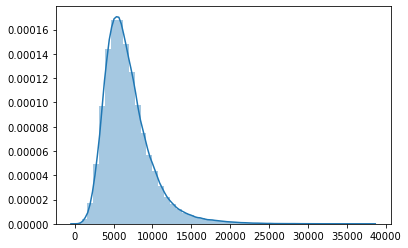

In [66]:
sns.distplot(y)

### train test split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [68]:
assert len(X_train) + len(X_test) == len(X)

In [69]:
assert len(X_train) == len(y_train)

In [70]:
X_train.shape

(330319, 27)

### Baseline Random Forest

In [71]:
rf = RandomForestRegressor(n_estimators=100, 
                           min_samples_leaf=3, 
                           max_depth=5, 
                           random_state=42)

In [72]:
rf.fit(X_train, y_train)

<ipython-input-72-168a6fc83696>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [73]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [74]:
y_pred = rf.predict(X_test)

In [77]:
rf_base_metric = metric(y_pred, y_test.values)

print("Metric for baseline prediction = {}".format(rf_base_metric))

Metric for baseline prediction = 19.78726279017417
